In [21]:
%matplotlib inline
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import scipy.stats as st
import pandas as pd
norminv = st.distributions.norm.ppf
norm = st.distributions.norm.cdf
from random import gauss
from latex_envs.latex_envs import figcaption

<div class="alert alert-block alert-info">
    <h1>Certificate in Quantitative Finance <a class="tocSkip"></h1>
        <h4>Assignment for Module 3 <a class="tocSkip"></h4>
            <h3>April 2019 <a class="tocSkip"></h3>
#
                <h2>Syed Raif Sayeed <a class="tocSkip"></h2>
</div>

## Task
Use the expected value of the discounted payoff under the risk-neutral density $ \mathbb{Q} $
\begin{equation}
\label{eq:riskneut}
V (S, t) = e^{-r(T-t)} {E}^{Q}[ \text{ Payoff} (S_T)]
\end{equation}
for the appropriate form of payoff, to consider:
1. Binary Options
2. Lookback Options: fixed and floating strike; discrete and continuous sampling

In both cases use the Euler-Maruyama scheme for initially simulating the underlying stock price. As an initial example, you may use the following set of sample data

\begin{align*}
\text{Today's  stock  price}\   S_0 &= 100 \\
\text{Strike}\   E &= 100 \\
\text{Time to expiry}\   (T - t) &= 1 year \\
\text{volatility}\ \sigma &= 20\% \\
\text{constant risk-free interest rate}\ r &= 5\% 
\end{align*}

In [2]:
init_args = [100, 100, 1, 0.2, 0.05]

## Solution

### Introduction:

The **Euler-Maruyama** method (also called the **Euler** method) provides an approximate numerical solution of a stochastic differential equation (SDE). It is helpful to simulate the entire price path in a monte-carlo simulation. For example in our equation \ref{eq:riskneut}, we can simulate the $ S_T $.

Note that the fair value of an option is the present value of the expected payoff at expiry under a *risk-neutral* random walk for the underlying. The risk-neutral random walk for $ S $ is:

\begin{align}
    \label{eq:genGBM}
    d S &= r S dt + \sigma S dX
\end{align}

This is simply our usual lognormal random walk but with the risk-free rate instead of the real growth rate. Also note that the $ X $ here is the Wiener process.

Using Euler-Maruyama, price paths are simulated using a discrete version of the stochastic differential equation for $ S $.
An obvious choice is to use:

\begin{align}
    \label{eq:EulerGBM}
    \delta S &= r S \delta t + \sigma S \sqrt{\delta t} \phi
\end{align}

where $ \phi $ is from a standardized Normal distribution, whose cumulative distribution function is given by:

\begin{eqnarray}
\label{eq:NormCDF}
\mathcal{N}(x) = \frac{1}{\sqrt{2 \pi}} \int^x_{-\infty} e^{-t^{2} /2} dt
\end{eqnarray}

Essentially we're saying that each Brownian increment $ X_i $ is computed by multiplying a standard normal variable $ \phi_i $ from a normal distribution $ \mathcal{N}\left(0,1\right) $ with mean 0 and standard deviation 1, by the square root of the increment $ \sqrt{\delta t_i} $

Or, we can understand the step $ S_{t + \delta t} $ as:

\begin{align}
    S_{t+ \delta t} &= S_t \left( 1 + r \delta t + \sigma \phi \sqrt{\delta t} \right)
\end{align}

which is equivalent to Equation \ref{eq:EulerGBM} above.

We also know that the general GBM equation in \ref{eq:genGBM} above, has the solution:

\begin{equation}
\label{eq:stGBM}
S_t=S_0\exp{\left((r-\frac{\sigma^2}{2})t + \sigma X_t\right)}
\end{equation}

which can be shown to also follow the standard time-step as below (given Wiener process has independent normally distributed increments $ \sqrt{t} $.

\begin{equation}
S_{t_{i+1}} = S_{t_i} \exp \left( ( r_{t_i , t_{i+1}} - \frac{\sigma^2}{2} ) (t_{i+1} - t_i) + \sigma \sqrt{t_{i+1} - t_i } \phi_i \right), \quad \phi_i \sim N(0,1)
\end{equation}

### First Step: A Closed Form Black Scholes

We start by implementing a one time-step function to price a vanilla european option using the solution of GBM SDE from equation \ref{eq:genGBM} and compare to an actual Black Scholes closed form function. This is to ensure that our basic code matches the known closed-form solutions closely.

\begin{align}
\text{Black Scholes solution gives Call value:}\\
C(S,t) &= SN(d_1) - Ke^{-r(T - t)} N(d_2) \\
\text{and Put value:}\\
P(S,t) &= Ke^{-r(T - t)}N(-d_2) - SN(-d_1) \\
\text{where } \\
d_1 &= \frac{\ln \left(\frac{S}{K} \right) + \left(r + \frac{\sigma^2}{2} \right)(T - t)}{\sigma \sqrt{T - t}} \\
d_2 &= d_1 - \sigma \sqrt{T - t} = \frac{\ln \left(\frac{S}{K} \right) + \left(r - \frac{\sigma^2}{2}\right)(T - t)}{\sigma \sqrt{T - t}}
\end{align}

In [3]:
def euro_vanilla(S, K, T, sigma, r, option = 'call'):
    
    #S: spot price
    #K: strike price
    #T: time to maturity
    #r: interest rate
    #sigma: volatility of underlying asset
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    
    if option == 'call':
        result = (S * st.norm.cdf(d1, 0.0, 1.0) - K * np.exp(-r * T) * st.norm.cdf(d2, 0.0, 1.0))
    if option == 'put':
        result = (K * np.exp(-r * T) * st.norm.cdf(-d2, 0.0, 1.0) - S * st.norm.cdf(-d1, 0.0, 1.0))
        
    return result

In [26]:
S0 = init_args[0]
E = init_args[1]
Time_to_expiry = init_args[2]
vol = init_args[3]
rf = init_args[4]
BScallval = euro_vanilla(S0, E, Time_to_expiry, vol, rf, option = 'call')

In [5]:
euro_vanilla(100,100,1,0.2,0.05,option='call')

10.450583572185565

### Generating Discrete Euler-Maruyama Time-steps

We can generalize the following for an asset price at time-step $ t_N $:
\begin{equation}
\label{eq:EMD}
\text{Euler-Maruyama :} \quad S_N = S_0 \prod_{i=0}^{N-1} \left(1+ \tilde{r}_i \Delta t_i + \sigma \sqrt{\Delta t_i} \phi_i \right)
\end{equation}

#### Errors

The Euler method has an error of $ \mathcal{O} \left( \delta t \right) $.

There are at least two sources of error in the Monte Carlo Method:
\begin{itemize}
\item If the size of the time steps is $ \delta t$ then we may introduce errors of $\mathcal{O} \left(\delta t\right)$ due to discrete approximation to continuous events.
\item We simulate a finite number out of an infinite number of possible paths - the error due to using $ N $ realizations of the asset price paths is $\mathcal{O}\left( N^{-1/2}\right)$.
\end{itemize}

We can study the errors by modulating $ M $, the number of paths and $ N $, the number of sampling times.

#### Generating the Asset Price

We create a function to generate the Asset price in two possible ways - one with the solution of the standard GBM, i.e. the equation \ref{eq:stGBM} above; and the other using equation \ref{eq:EMD} above.

In [17]:
def ts_price_gen(M, N, S0, T, sigma, r, scheme = 'euler'):
    unif_samples = np.random.uniform(size=(M,N))
    norm_samples = norminv(unif_samples)
    dtsize = 1/N
    t_arr = np.arange(0,T,dtsize)
    dt_steps_arr = np.diff(np.append(np.array([0]),t_arr))
    rf_t = np.array([r for i in t_arr])
    sqrt_dt = np.sqrt(dt_steps_arr)
    if scheme == 'gbm':
        increments = np.exp((rf_t - 0.5*(sigma**2))*t_arr + sigma*(np.cumsum(sqrt_dt*norm_samples,axis=1)))
    elif scheme == 'euler':
        increments = np.cumprod(1 + rf_t*dt_steps_arr + sqrt_dt*sigma*norm_samples,axis=1)
    else:
        print('Error! Cannot identify scheme type!')
        return None
    prices = S0*increments
    return prices

We can set $ M $ paths and $ N $ times for our initial runs and generate `gbm_prices` and `em_prices` (from Euler-Maruyama scheme).

In [18]:
M = 10000
N = 252
gbm_prices = ts_price_gen(M, N, S0, Time_to_expiry, vol, rf,'gbm')
em_prices = ts_price_gen(M, N, S0, Time_to_expiry, vol, rf,'euler')

We can observe them visually as below.
#### GBM Prices plot

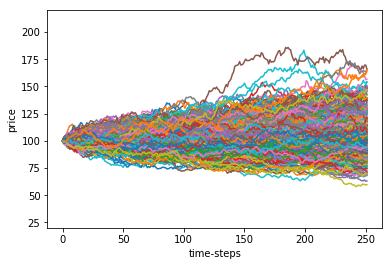

In [24]:
for aa in range(N):
    plt.plot(range(N),gbm_prices[aa])
axes = plt.gca()
axes.set_ylim([20,220])
plt.ylabel('price')
plt.xlabel('time-steps')
plt.show()

#### Euler-Maruyama Prices plot

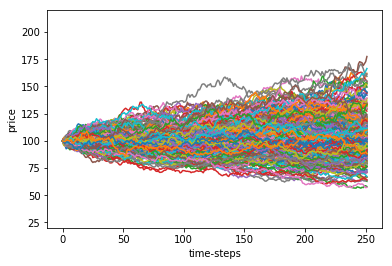

In [25]:
for aa in range(N):
    plt.plot(range(N),em_prices[aa])
axes = plt.gca()
axes.set_ylim([20,220])
plt.ylabel('price')
plt.xlabel('time-steps')
plt.show()

#### Pricing Vanilla European Options

Now that we have the asset price evolution, let's price a vanilla European option and see how it matches with standard Black Scholes.

In [44]:
step_vals = np.exp(-rf*Time_to_expiry)*np.maximum(0, em_prices - E)
last_step_vals = step_vals[:,N-1]
em_call_price = np.mean(last_step_vals)
print('The value of a European Call using standard Black Scholes closed form is {:.5f}, '
      'while using Euler Maruyama scheme based Monte Carlo is {:.5f}.'.format(BScallval, em_call_price))

The value of a European Call using standard Black Scholes closed form is 10.45058, while using Euler Maruyama scheme based Monte Carlo is 10.72421.


### Pricing a Binary Option

A binary option is an option with a discontinuous payoff. A simple example is the cash-or-nothing or digital option. It is an option where the payoff is either some amount or nothing at all. The payoff is, usually, a fixed amount of cash or the value of the asset. 

Thus for a **Cash-or-Nothing Digital Call**, the payoff at maturity is:

$ C^b_T $ = 0 if $ S(T) \leq K $; else

$ C^b_T $ = 1 if $ S(T) > K $

and it's just the mirror image for a **Cash-or-Nothing Digital Put** as:

$ P^b_T $ = 1 if $ S(T) < K $; else

$ P^b_T $ = 0 if $ S(T) \geq K $

#### Closed form solution for Binary Option

The Closed form solution for a **Cash-or-Nothing Digital Call** is given by:

\begin{equation}
C = Q e^{-rT}N(d_2)
\end{equation}

where $ Q $ is a cash amount (we can assume Q = 1 for descriptive purposes).

Similarly, the closed form solution for a **Cash-or-Nothing Digital Put** is given by:

\begin{equation}
C = Q e^{-rT}N(-d_2)
\end{equation}

We can use our initial values to get the closed-form value of a Cash-or-Nothing Call.

In [35]:
def binary_closed_form(S, K, r, T, sigma,option='call'):
    d2 = (np.log(S/K) + (r - 0.5*(sigma**2))*T) / (sigma*np.sqrt(T))
    if option=='call':
        bin_price = np.exp(-r*T) * norm(d2)
    else:
        bin_price = np.exp(-r*T) * norm(-d2)
    return bin_price

In [45]:
bin_cf_price = binary_closed_form(S0, E, rf, Time_to_expiry, vol,'call')
#bin_cf_price = binary_closed_form(S0, E, rf, Time_to_expiry, vol,'put')

In [38]:
print(bin_cf_price)

0.5323248154537634


#### Monte-Carlo solution for European Cash-or-Nothing Binary Option

We first define a function for the payoff of the Binary Call/Put, and then use our Euler-Maruyama prices (`em_prices`) to create payoffs at each time-step. Then for the last time-step of each path, we take the mean to arrive at the option price.

In [39]:
def payoff_binary_call(St, K):
    if St > K:
        return 1.0
    else:
        return 0.0

def payoff_binary_put(St, K):
    if St < K:
        return 1.0
    else:
        return 0.0

In [46]:
E_t = np.full(N,E)
np_bin_payoff = np.vectorize(payoff_binary_call)
#np_bin_payoff = np.vectorize(payoff_binary_put)
b_step_vals = np.exp(-rf*Time_to_expiry)*np_bin_payoff(em_prices,E_t)
b_end_vals = b_step_vals[:,N-1]
bin_mc_price = np.mean(b_end_vals)

In [43]:
print('The value of a Digital Call using closed form solution is {:.5f}, '
      'while using Euler Maruyama scheme based Monte Carlo is {:.5f}.'.format(bin_cf_price, bin_mc_price))

The value of a Digital Call using closed form solution is 0.53232, while using Euler Maruyama scheme based Monte Carlo is 0.53773.


### Pricing a Lookback Option

#### Analytical Pricing

A **Floating-Strike European Lookback Option** has a payoff for a Call and Put as follows:

\begin{eqnarray}
fl_C (S) &=& \max(S_T - S_{\min}, 0) \\
fl_P (S) &=& \max(S_{\max} - S_T, 0)
\end{eqnarray}

Let $ M $ and $ m $ be the maximum and minimum prices of the underlying asset over the option duration:
\begin{eqnarray*}
M &=& \smash{\displaystyle\max_{0 \leq \tau \leq T}} S_{\tau} 
\end{eqnarray*}

\begin{eqnarray*}
m &=& \smash{\displaystyle\min_{0 \leq \tau \leq T}} S_{\tau}
\end{eqnarray*}

Then the prices of Floating Strike European Lookback Calls and Puts is given by:


\begin{eqnarray}
L_C (T) &=& SN(a_1(S,m)) - me^{-rT}N(a_2(S,m)) - \frac{S \sigma^2}{2r}\left( N(-a_1(S,m)) - e^{-rT}(m/S)^{\frac{2r}{\sigma^2}}N(-a_3(S,m)) \right) \\
L_P (T) &=& -SN(-a_1(S,M)) + Me^{-rT}N(-a_2(S,M)) + \frac{S \sigma^2}{2r}\left( N(a_1(S,M)) - e^{-rT}(M/S)^{\frac{2r}{\sigma^2}}N(a_3(S,M)) \right) 
\end{eqnarray}

where $ N (.) $ is the cumulative distribution function of the standard normal distribution, i.e. equation \ref{eq:NormCDF} above. 

Given below are the equations for $ a_1 , a_2 , a_3 $ for the pair $ (S, S_H) $, where $ S_H $ is the min/max of asset price over period (to be used as per the equations above).

\begin{eqnarray}
a_1(S,S_H) &=& \frac{log(S/S_H)+(r+\frac{1}{2}\sigma^2)T}{\sigma \sqrt{T}} \\
a_2(S,S_H) &=& a_1(S,S_H) - \sigma \sqrt{T} \\
a_3(S,S_H) &=& a_1(S,S_H) - \frac{2r\sqrt{T}}{\sigma}
\end{eqnarray}

In [47]:
"""
Floating Lookback Option
-=-=-=-=-=-=-=-=-=-=-=-=-
In the formulas, note that
S => Spot Price
H => Min/max of asset price over period
r => risk-free rate
sigma => volatility of underlying asset
T => Time to expiry
m => minimum price of asset over period
M => Maximum price of asset over period
"""

def a_1(S, H, r, sigma, T):
    nn = np.log(S/H) + (r + 0.5*(sigma**2))*T
    dd = sigma * np.sqrt(T)
    a1 = nn/dd
    return a1

def a_2(S, H, r, sigma, T):
    a2 = a_1(S, H, r, sigma, T) - sigma*np.sqrt(T)
    return a2

def a_3(S, H, r, sigma, T):
    a3 = a_1(S, H, r, sigma, T) - (2.0*r*np.sqrt(T)/sigma)
    return a3

def lookback_fl_call(S, m, r, sigma, T):
    a1 = a_1(S, m, r, sigma, T)
    a2 = a_2(S, m, r, sigma, T)
    a3 = a_3(S, m, r, sigma, T)
    term1 = S * norm(a1)
    term2 = m * np.exp(-r*T) * norm(a2)
    term3 = norm(-a1) - np.exp(-r*T)*((m/S)**(2*r/(sigma**2)))*norm(-a3)
    mult = (S*(sigma**2)/(2*r))
    pr = term1 - term2 - (mult*term3)
    return pr

def lookback_fl_put(S, M, r, sigma, T):
    a1 = a_1(S, M, r, sigma, T)
    a2 = a_2(S, M, r, sigma, T)
    a3 = a_3(S, M, r, sigma, T)
    term1 = -S * norm(-a1)
    term2 = M * np.exp(-r*T) * norm(-a2)
    term3 = norm(a1) - np.exp(-r*T)*((M/S)**((2*r)/sigma**2))*norm(a3)
    mult = (S*(sigma**2)/(2*r))
    pr = term1 + term2 + (mult*term3)
    return pr

#### Monte-Carlo Solution

In [49]:
S_min = em_prices.min(axis=1)
S_T = em_prices[:,N-1]
fl_step_vals = np.exp(-rf*Time_to_expiry)*np.maximum(0, S_T - S_min)
fl_mc_price = np.mean(fl_step_vals)

In [50]:
"""
Compare Analytical vs MC
"""
Sm = np.mean(S_min)
fl_bs_price = lookback_fl_call(100,Sm,rf,vol,Time_to_expiry)

In [51]:
print('The value of a Floating Lookback Call using closed form solution is {:.5f}, '
      'while using Euler Maruyama scheme based Monte Carlo is {:.5f}.'.format(fl_bs_price, fl_mc_price))

The value of a Floating Lookback Call using closed form solution is 20.48289, while using Euler Maruyama scheme based Monte Carlo is 16.83934.
